## Initialization

In [1]:
#! pip install -q lalsuite
#! pip install -q gwpy
#! pip install -q pycbc
#! pip install -q lalsuite==6.82 bilby==1.0.4 gwpy==2.0.2 matplotlib==3.2.2 dynesty==1.0.0

# -- Click "restart runtime" in the runtime menu

In [2]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

print(bilby.__version__)

--2022-05-29 22:39:33--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  9.13MB/s    in 28s     

2022-05-29 22:40:02 (8.77 MB/s) - ‘challenge3.gwf’ saved [256815066/256815066]



### Read data

In [3]:
#sampling_rate=2048 #needs to be high enough for the signals found in steps above
sampling_rate=4096 #needs to be high enough for the signals found in steps above

parameter_set = 3
if parameter_set == 1:
    # 10 M_sun
    label_mass_from_mf = '10'
    mass_from_mf_min = 8.5
    mass_from_mf_max = 12.5
    duration=2.4 #needs to be long enough for the signals found in steps above
    start_time=2481.8 #needs to be set so that the segment defined by [start_time,start_time+duration] contains the signal
else if parameter_set == 2:
    # 17 M_sun
    mass_from_mf_min = 14
    mass_from_mf_max = 19
    label_mass_from_mf = '17'
    duration=4
    start_time=1637
else if parameter_set == 3:
    # 22 M_sun
    mass_from_mf_min = 17
    mass_from_mf_max = 28
    label_mass_from_mf = '22'
    duration=1
    start_time=1203.8
else if parameter_set == 4:
    # 31 M_sun
    mass_from_mf_min = 26
    mass_from_mf_max = 35
    label_mass_from_mf = '31'
    duration=0.8
    start_time=2994.8
else if parameter_set == 5:
    # 35 M_sun
    mass_from_mf_min = 31
    mass_from_mf_max = 40
    label_mass_from_mf = '35'
    duration=0.5
    start_time=3318.9

In [3]:
psd_duration = duration * 32
psd_start_time = start_time - psd_duration

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1','L1']:
    ifo=bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel=ifo_name+':CHALLENGE3')
    
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity.from_frame_file('challenge3.gwf', psd_start_time ,
                                                                                        psd_duration=psd_duration, fft_length=duration ,
                                                                                        sampling_frequency=sampling_rate, roll_off= ifo.strain_data.roll_off,
                                                                                        channel=ifo_name+':CHALLENGE3')
    
    #gwpy_strain = TimeSeries.read('challenge3.gwf', channel=ifo_name+":CHALLENGE3")
    #sampling_rate_raw=1/gwpy_strain.dt
    #segment = (int((start_time-psd_duration)*sampling_rate_raw.value), int((start_time)*sampling_rate_raw.value))
    #ifo_psd_data = gwpy_strain[segment[0]:segment[1]]
    
    #psd_alpha = 2 * ifo.strain_data.roll_off / duration
    #ifo_psd = ifo_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
    #ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=ifo_psd.frequencies.value, psd_array=ifo_psd.value)
    
    interferometers.append(ifo)

22:40 bilby INFO    : Reading data from frame file challenge3.gwf
22:40 bilby INFO    : Successfully loaded H1:CHALLENGE3.
22:40 bilby INFO    : Reading data from frame file challenge3.gwf
22:40 bilby INFO    : Successfully loaded H1:CHALLENGE3.
22:40 bilby INFO    : Tukey window PSD data with alpha=0.4, roll off=0.2
22:40 bilby INFO    : Reading data from frame file challenge3.gwf
22:40 bilby INFO    : Successfully loaded L1:CHALLENGE3.
22:40 bilby INFO    : Reading data from frame file challenge3.gwf
22:40 bilby INFO    : Successfully loaded L1:CHALLENGE3.
22:40 bilby INFO    : Tukey window PSD data with alpha=0.4, roll off=0.2


#### Note: In order to generate frequency_domain_strain of the same length as frequency_mask, sampling rate needs to be high enough

In [4]:
print(len(interferometers[0].strain_data.frequency_mask))
print(len(interferometers[0].strain_data.frequency_domain_strain))
print(len(interferometers[0].power_spectral_density.frequency_array))

22:40 bilby INFO    : Generating frequency domain strain from given time domain strain.
22:40 bilby INFO    : Applying a tukey window with alpha=0.4, roll off=0.2


2049
2049
2049


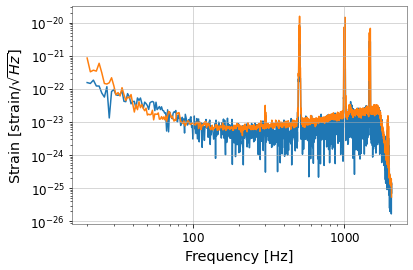

In [5]:
fig, ax = plt.subplots()
idxs = interferometers[0].strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(interferometers[0].strain_data.frequency_array[idxs],
          np.abs(interferometers[0].strain_data.frequency_domain_strain[idxs]))
ax.loglog(interferometers[0].power_spectral_density.frequency_array[idxs],
          interferometers[0].power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [6]:
interferometers[0].maximum_frequency = 1024
interferometers[1].maximum_frequency = 1024

### Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and geocent_time parameters to fixed values. The first two were described above. The second two give the phase of the system and the time at which it merges.

In [7]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=mass_from_mf_min,maximum=mass_from_mf_max)
prior['mass_ratio'] = 1.0
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=start_time, maximum=start_time+duration)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066


## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's create a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [8]:
# First, put our "data" created above into a list of interferometers (the order is arbitrary)
#interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

22:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Note that we also specify `time_marginalization=True` and `phase_marginalization=True`. This is a trick often used in Bayesian inference. We analytically marginalize (integrate) over the time/phase of the system while sampling, effectively reducing the parameter space and making it easier to sample. Bilby will then figure out (after the sampling) posteriors for these marginalized parameters. For an introduction to this topic, see [Thrane & Talbot (2019)](https://arxiv.org/abs/1809.02293).

### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [ ]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label=label_mass_from_mf,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    #sample="unif",
    sample="rwalk_dynesty",
    nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

22:40 bilby INFO    : Running for label '22', output will be saved to 'short'
22:40 bilby INFO    : Using lal version 7.1.6
22:40 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.6;Id: 4f664fffa723bbbe3610d9b29555ee8dc903ab97;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
22:40 bilby INFO    : Using lalsimulation version 3.1.1
22:40 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.1;Id: 9eff85db5692ef91b1db038801d68a1f3d13d89b;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
22:40 bilby INFO    : Search parameters:
22:40 bilby INFO    :   chirp_mass = Uniform(minimum=17, maximum=28, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
22:40 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.000244140625, name='time_jitter', latex_label='$t_j$', unit=None, boundary='periodic')
22:40 bilby I

0it [00:00, ?it/s]

22:41 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk_dynesty', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f1eb6e90cd0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
22:41 bilby INFO    : Checkpoint every check_point_delta_t = 600s
22:41 bilby INFO    : Using dynesty version 1.0.1
22:41 bilby INFO    : Using t

### Looking at the outputs

The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet); let's take a look at it

In [ ]:
result_short.posterior

We can pull out specific parameters that we are interested in

In [ ]:
Mc = result_short.posterior["chirp_mass"].values
m1 = Mc/2**(1.0/5.0)

We can then get some useful quantities such as the 90\% credible interval

In [ ]:
lower_bound = np.quantile(m1, 0.05)
upper_bound = np.quantile(m1, 0.95)
median = np.quantile(m1, 0.5)
print("m1 = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

We can then plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.

In [ ]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"]/2**(1.0/5.0), bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("component mass")
plt.show()